In [ ]:
import tensorflow as tf

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_file = 'UK_normalised_indicators_9.xlsx'
df = pd.read_excel(data_file)

In [3]:
df = pd.DataFrame(df)
df.index = df.pop('Date')

In [4]:
df

,GDP,PPI,Interest Rates,CPI
Date,,,,
1960 Q2,0.581780,0.291120,0.430702,0.132092
1960 Q3,0.582033,0.288975,0.412689,0.126773
1960 Q4,0.582336,0.287985,0.391633,0.137412
1961 Q1,0.582561,0.290295,0.372021,0.131383
1961 Q2,0.581353,0.290296,0.390753,0.139894
...,...,...,...,...
2021 Q4,0.690986,0.569106,0.634533,0.562500
2022 Q1,0.665595,0.644383,0.747834,0.416667
2022 Q2,0.674904,1.000000,0.719037,1.000000


In [ ]:
df_CPI =  pd.DataFrame(df["CPI"])

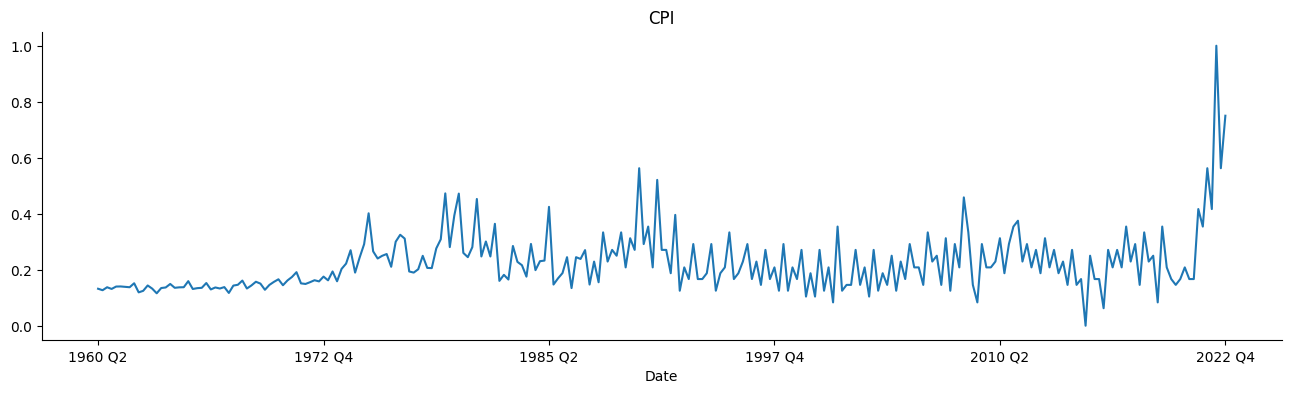

In [ ]:
from matplotlib import pyplot as plt
df_CPI['CPI'].plot(kind='line', figsize=(16, 4), title='CPI')
plt.gca().spines[['top', 'right']].set_visible(False)

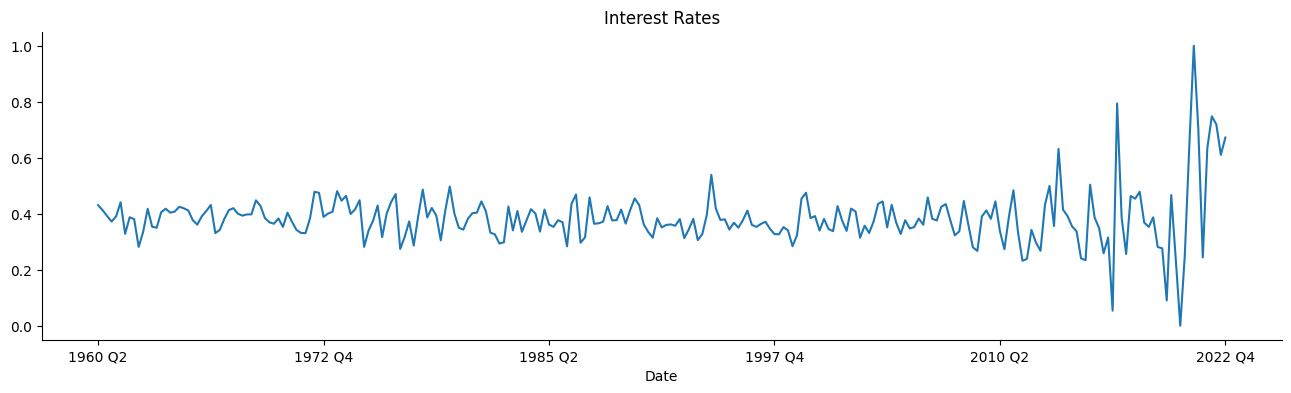

In [ ]:
df_unrate =  pd.DataFrame(df["Interest Rates"])
df_unrate['Interest Rates'].plot(kind='line', figsize=(16, 4), title='Interest Rates')
plt.gca().spines[['top', 'right']].set_visible(False)

In [5]:
def df_to_X_y(df,window_size=8):
  df_as_np = df.to_numpy()
  date_as_np = df_date.to_numpy()
  X=[]
  y=[]
  date_data=[]
  for i in range(len(df_as_np)-window_size):
    rows = [a for a in df_as_np[i:i+window_size]]
    X.append(rows)
    output_row=  df_as_np[i+window_size]
    label = output_row[3]
    date = date_as_np[i+window_size]
    y.append(label)
    date_data.append(date)
  return np.array(X),np.array(y),np.array(date_data)

In [6]:
date_data= df.index


In [7]:
df_date = pd.DataFrame(date_data)


In [8]:
WINDOW_SIZE = 6
X, y ,date_window= df_to_X_y(df,WINDOW_SIZE)

In [9]:
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))

In [10]:
X_train, y_train = X[:train_size], y[:train_size]
X_val , y_val = X[train_size: train_size + val_size], y[train_size: train_size + val_size]
X_test ,y_test = X[train_size + val_size:], y[train_size + val_size:]

In [11]:
date_train = date_window[:train_size]
date_val  = date_window[train_size: train_size + val_size]
date_test  = date_window[train_size + val_size:]

In [12]:
X_test.shape, y_test.shape, date_test.shape

((50, 6, 4), (50,), (50, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions1(model, X, y, date):
    predictions = model.predict(X).flatten()
    date = date.flatten().tolist()

    # Calculate the index to start calculating MSE and RMSE from
    start_index = date.index('2011 Q4')

    # Manually add 2011 Q1, Q2, Q3 to the beginning of the date array
    date = ['2011 Q1', '2011 Q2', '2011 Q3'] + date[start_index:]
    predictions = [None, None, None] + predictions.tolist()[start_index:]
    y = [None, None, None] + y.tolist()[start_index:]

    df_graph = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})

    total_error = 0  # Initialize total error to calculate average error
    num_valid_samples = 0  # Initialize count of valid samples (non-None)
    rmse_values=[]

    for i, (pred, actual) in enumerate(zip(predictions, y)):
      if pred is not None and actual is not None:
        error = mse([actual], [pred])  # Calculate MSE for current prediction and actual value
        rmse = np.sqrt(error)
        print(f"Prediction {i+1}: {pred}, Actual: {actual}, MSE: {error}, RMSE: {rmse}")
        total_error += error
        num_valid_samples += 1
        rmse_values.append(rmse)

    avg_error = total_error / num_valid_samples  # Calculate average error using only valid samples
    final_rmse = np.sqrt(avg_error)
    print(f"Average MSE: {avg_error}")
    print("Final RMSE: ", final_rmse)

    plt.figure(figsize=(48, 25))
    plt.plot(date, df_graph['Predictions'], label='Predictions', color='red')  # Specify color for predictions
    plt.plot(date, df_graph['Actuals'], label='Actuals', color='blue')  # Specify color for actual values
    plt.legend(fontsize=40)  # Add legend to the plot
    plt.xlabel('Date', fontsize=45)
    plt.ylabel('Value', fontsize=45)
    plt.title('Predictions vs Actuals', fontsize=50)
    plt.xticks(fontsize=30)  # Change font size of x-axis ticks
    plt.yticks(fontsize=35)
    plt.grid(True)

    # Set x-axis ticks to show only the selected quarters
    plt.xticks(date[::4])

    plt.show()

    return df_graph, mse([x for x in y if x is not None], [x for x in predictions if x is not None]), final_rmse, rmse_values


In [ ]:
import random
def get_hyper_param(iterations_no):
  hyper_param = [] #lstm1_neurons, lstm2_neurons, lstm3_neurons, dense_neurons, dense2_neurons, learning_rate,  epochs, batch_size
  for i in range(iterations_no):
    current_params = []
    current_params.append(np.random.randint(8,513))  #lstm1_neurons
    current_params.append(np.random.randint(8,513))  # lstm2_neurons
    current_params.append(np.random.randint(8,513))  # lstm3_neurons
    current_params.append(np.random.randint(8,513))  # dense_neurons
    current_params.append(np.random.randint(8,513)) # dense2_neurons
    current_params.append(random.choice([0.00001,0.0001,0.001,0.01,0.1])) #learning rate
    current_params.append(random.choice([100,150,200])) #epochs
    current_params.append(random.choice([8,16,32,64,128])) #batch size
    hyper_param.append(current_params)

  return hyper_param

hyper_parameter = get_hyper_param(100)
hyper_parameter


[[488, 494, 415, 388, 82, 0.01, 100, 64],
 [241, 379, 356, 454, 494, 0.1, 100, 64],
 [396, 449, 8, 413, 43, 1e-05, 200, 32],
 [26, 464, 196, 349, 140, 0.01, 150, 128],
 [117, 8, 216, 205, 56, 0.001, 200, 64],
 [117, 440, 138, 109, 135, 0.1, 100, 32],
 [238, 458, 145, 403, 119, 1e-05, 100, 32],
 [291, 168, 419, 122, 485, 1e-05, 200, 128],
 [155, 258, 180, 195, 463, 1e-05, 150, 128],
 [29, 261, 101, 280, 401, 0.0001, 100, 64],
 [492, 476, 314, 172, 248, 0.01, 200, 128],
 [483, 439, 328, 481, 498, 0.1, 150, 8],
 [422, 314, 396, 61, 227, 0.01, 150, 8],
 [190, 276, 232, 429, 168, 0.0001, 200, 64],
 [237, 181, 35, 316, 438, 0.0001, 150, 32],
 [246, 393, 118, 104, 174, 0.01, 100, 16],
 [141, 181, 21, 40, 381, 0.01, 100, 8],
 [269, 294, 153, 297, 420, 0.0001, 100, 128],
 [198, 60, 59, 377, 17, 0.0001, 200, 8],
 [329, 318, 165, 425, 256, 0.1, 150, 16],
 [403, 117, 220, 428, 235, 0.0001, 200, 128],
 [139, 113, 396, 383, 295, 0.0001, 200, 16],
 [485, 169, 270, 509, 75, 0.0001, 150, 64],
 [98, 61,

In [ ]:
train_loss, train_root_mean_sqr_error, val_loss, val_root_mean_sqr_error = list(), list(), list(), list()
best_params =[]
def fit_lstm_random(batch_size):
  min_val_loss = 999
  min_test_loss = 999
  for lstm1_neurons, lstm2_neurons,lstm3_neurons,dense_neurons,dense2_neurons, learning_rate,n_epochs, batch_size in hyper_parameter:
    model = Sequential()
    model.add(LSTM(lstm1_neurons,input_shape=(6,4),return_sequences=True,activation ='tanh'))
    model.add(Dropout(0.0))

    model.add(LSTM(lstm2_neurons,return_sequences = True,activation ='tanh'))
    model.add(Dropout(0.0))

    model.add(LSTM(lstm3_neurons,return_sequences = False,activation ='tanh'))
    model.add(Dropout(0.0))

    model.add(Dense(dense_neurons,activation = 'linear'))
    model.add(Dropout(0.0))

    model.add(Dense(dense2_neurons,activation = 'linear'))
    model.add(Dropout(0.0))

    model.add(Dense(1,activation = "linear"))
    model.compile(loss=MeanSquaredError(),optimizer = Adam(learning_rate=learning_rate),metrics = [RootMeanSquaredError()])
    lstm_model = model.fit(X_train,y_train, validation_data = (X_val,y_val),epochs = n_epochs,batch_size = batch_size,verbose = 2)
    current_val_loss = lstm_model.history['val_loss'][-1]
    test_results = model.evaluate(X_test, y_test, verbose=0)
    current_test_loss = test_results[0]

    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params= [lstm1_neurons, lstm2_neurons,lstm3_neurons,dense_neurons, dense2_neurons, learning_rate,  n_epochs, batch_size]
      print('best_params',best_params)
      print('min_val',min_val_loss)

  print('final best params',best_params)
  print('final best val error',min_val_loss)
  return best_params








In [ ]:
def run_lstm_random():
  n_batch = 80
  history = fit_lstm_random(n_batch)

In [ ]:
run_lstm_random()

Streaming output truncated to the last 5000 lines.
Epoch 2/200
21/21 - 0s - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1570 - 194ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541 - 187ms/epoch - 9ms/step
Epoch 4/200
21/21 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495 - 190ms/epoch - 9ms/step
Epoch 5/200
21/21 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491 - 178ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512 - 184ms/epoch - 9ms/step
Epoch 7/200
21/21 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516 - 189ms/epoch - 9ms/step
Epoch 8/200
21/21 - 0s - 





lstm1_neurons, lstm2_neurons, dense_neurons, dense2_neurons, learning_rate, lstm1_drop, lstm2_drop, lstm1_activ, lstm2_activ, dense_activ, dense2_activ, epochs, batch_size



In [ ]:
model_tune = Sequential()

model_tune.add(LSTM(301,input_shape=(6,4),return_sequences=True,activation='tanh'))
model_tune.add(Dropout(0.0))

model_tune.add(LSTM(257,return_sequences=True,activation='tanh'))
model_tune.add(Dropout(0.0))

model_tune.add(LSTM(458,return_sequences=False,activation='tanh'))
model_tune.add(Dropout(0.0))

# model_tune.add(LSTM(470,return_sequences=False,activation='tanh'))
# model_tune.add(Dropout(0.8))

model_tune.add(Dense(511, 'linear'))
model_tune.add(Dropout(0.0))

model_tune.add(Dense(195, 'linear'))
model_tune.add(Dropout(0.0))


model_tune.add(Dense(1, activation='linear'))
model_tune.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 6, 301)            368424    
                                                                 
 dropout_55 (Dropout)        (None, 6, 301)            0         
                                                                 
 lstm_34 (LSTM)              (None, 6, 257)            574652    
                                                                 
 dropout_56 (Dropout)        (None, 6, 257)            0         
                                                                 
 lstm_35 (LSTM)              (None, 458)               1311712   
                                                                 
 dropout_57 (Dropout)        (None, 458)               0         
                                                                 
 dense_33 (Dense)            (None, 511)             

In [ ]:
cp_tune = ModelCheckpoint('model_tune/',save_best_only= True)
model_tune.compile(loss=MeanSquaredError(),optimizer = Adam(learning_rate= 0.001),metrics = [RootMeanSquaredError()])

In [ ]:
model_tune.fit(X_train, y_train,validation_data =(X_val, y_val),epochs = 150,callbacks=[cp_tune],batch_size=8)

Epoch 1/150
22/22 [==============================] - 16s 489ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 2/150
22/22 [==============================] - 0s 14ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 3/150
22/22 [==============================] - 0s 11ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863
Epoch 4/150
22/22 [==============================] - 0s 11ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 5/150
22/22 [==============================] - 0s 10ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 6/150
22/22 [==============================] - 0s 10ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0090 - va

2/2 [==============================] - 0s 7ms/step
Prediction 4: 0.22141733765602112, Actual: 0.2916666666666667, MSE: 0.0049349682264459285, RMSE: 0.07024932901064557
Prediction 5: 0.2482472062110901, Actual: 0.2083333333333333, MSE: 0.00159311724810173, RMSE: 0.0399138728777568
Prediction 6: 0.2917173504829407, Actual: 0.2708333333333334, MSE: 0.0004361421723050896, RMSE: 0.020884017149607248
Prediction 7: 0.15602760016918182, Actual: 0.1875, MSE: 0.000990511951110884, RMSE: 0.031472399830818176
Prediction 8: 0.2218751162290573, Actual: 0.3125, MSE: 0.008212869558496871, RMSE: 0.09062488377094269
Prediction 9: 0.17156438529491425, Actual: 0.2083333333333333, MSE: 0.0013519555398519595, RMSE: 0.03676894803841904
Prediction 10: 0.31898292899131775, Actual: 0.2708333333333334, MSE: 0.0023183835620273828, RMSE: 0.04814959565798432
Prediction 11: 0.15664267539978027, Actual: 0.1875, MSE: 0.0009521744814833255, RMSE: 0.030857324600219727
Prediction 12: 0.3362849950790405, Actual: 0.2291666

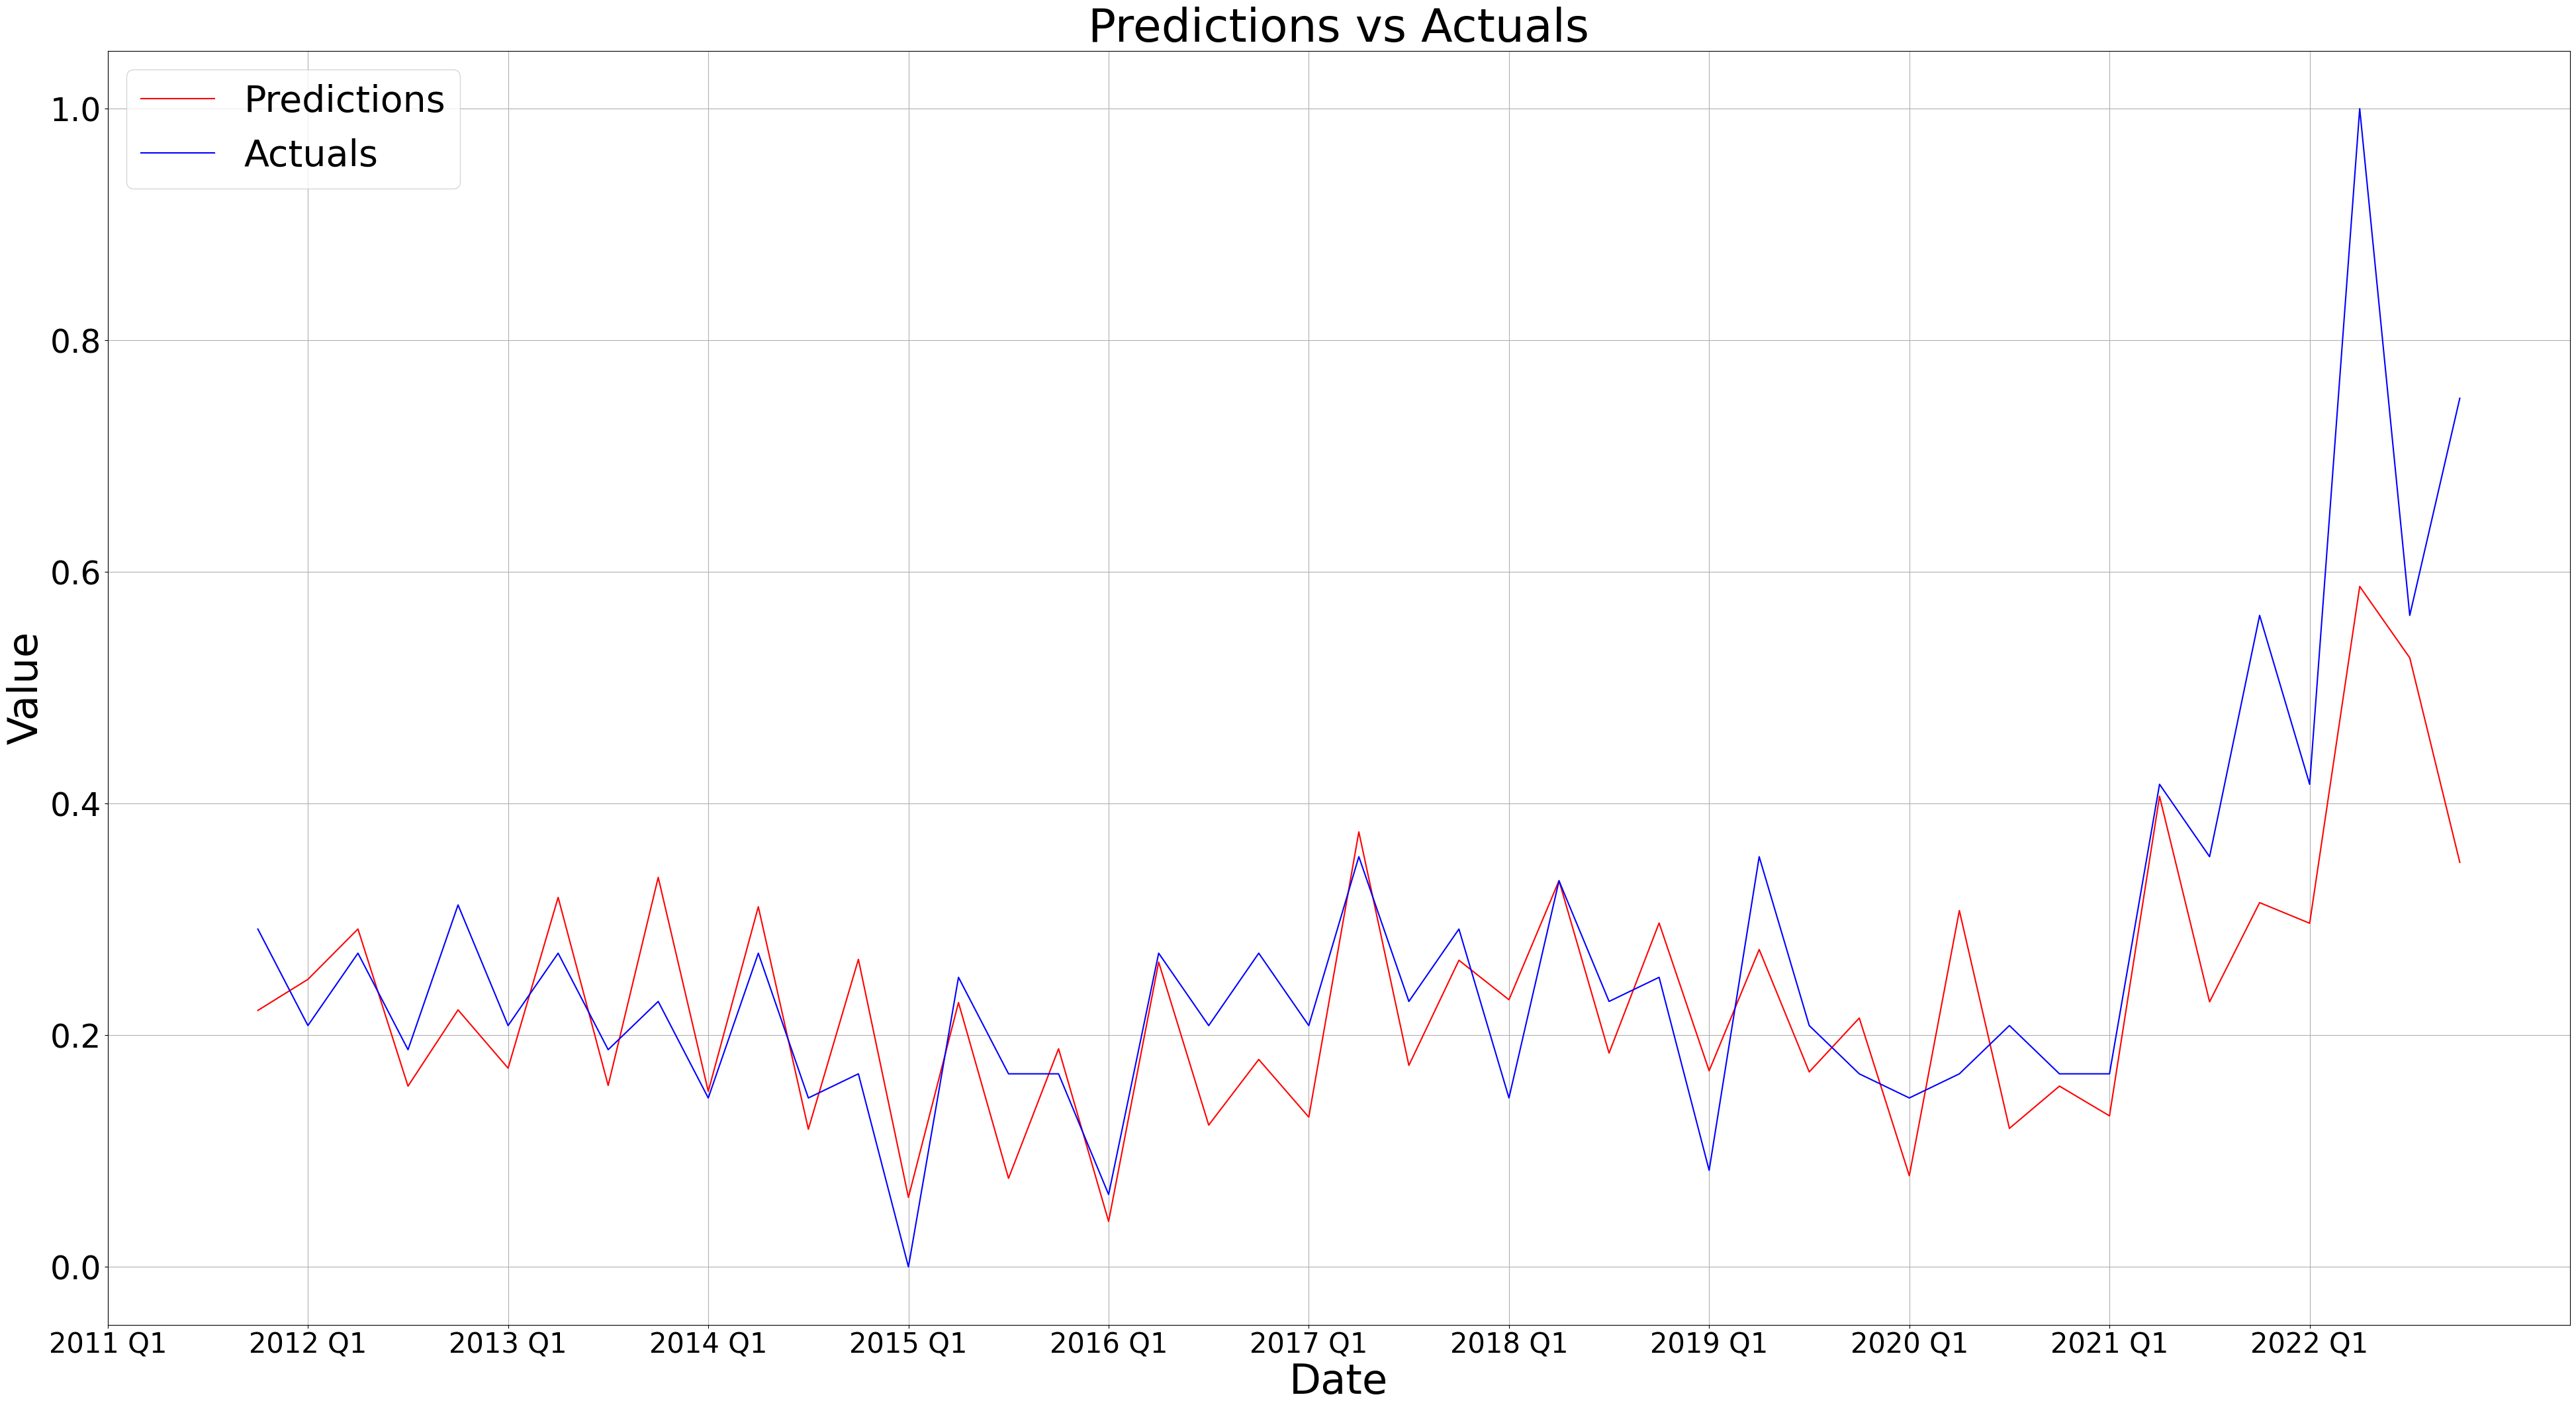

(    Predictions   Actuals
 0           NaN       NaN
 1           NaN       NaN
 2           NaN       NaN
 3      0.221417  0.291667
 4      0.248247  0.208333
 5      0.291717  0.270833
 6      0.156028  0.187500
 7      0.221875  0.312500
 8      0.171564  0.208333
 9      0.318983  0.270833
 10     0.156643  0.187500
 11     0.336285  0.229167
 12     0.151565  0.145833
 13     0.310925  0.270833
 14     0.118835  0.145833
 15     0.265507  0.166667
 16     0.059981  0.000000
 17     0.228223  0.250000
 18     0.076426  0.166667
 19     0.188322  0.166667
 20     0.039207  0.062500
 21     0.263133  0.270833
 22     0.122416  0.208333
 23     0.179067  0.270833
 24     0.129283  0.208333
 25     0.375547  0.354167
 26     0.173961  0.229167
 27     0.264738  0.291667
 28     0.230617  0.145833
 29     0.333455  0.333333
 30     0.184562  0.229167
 31     0.296915  0.250000
 32     0.169273  0.083333
 33     0.274004  0.354167
 34     0.168312  0.208333
 35     0.214842  0.166667
 

In [ ]:
plot_predictions1(model_tune,X_test,y_test,date_test)

In [13]:
X_train.shape,X_val.shape,X_test.shape,X.shape

((171, 6, 4), (24, 6, 4), (50, 6, 4), (245, 6, 4))